In [1]:
# The usual modular suspects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

# Of Mice & Machine Learning Mavericks
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import env
import os

In [3]:
# Acquisition

def get_telco_data(use_cache=True):
# filename = 'telco_churn.csv'
    
    if os.path.exists('telco.csv') and use_cache:
        print('Using cached csv')
        return pd.read_csv('telco.csv')
    print('Acquiring data from SQL database')
    df = pd.read_sql('''   
                    SELECT * 
                        FROM customers
                        JOIN contract_types USING(contract_type_id)
                        JOIN internet_service_types USING(internet_service_type_id)
                        JOIN payment_types USING(payment_type_id)
                    '''
            , get_db_url('telco_churn'))
    
    df.to_csv('telco.csv', index=False)
    
    return df



In [4]:
df = get_telco_data()

Using cached csv


In [5]:
def describe_data(df):
    print('The first three rows are: ')
    print('----------------------------------------------------------')
    print(df.head(3))
    print('----------------------------------------------------------')
    print("The data frame's shape is: ")
    print('-------------------------')
    print(f' Rows: {df.shape[0]} \n Columns: {df.shape[1]}')
    print('-------------------------')   
    print('The data types and column names are: ')
    print(sorted(df))
    print(df.info())
    print('----------------------------------------------------------')   
    print('The summary statistics are as follows: ')
    print('----------------------------------------------------------')
    print(df.describe())
    print('----------------------------------------------------------')      
    print(f'The number of NA\'s is:')
    print('-------------------------')
    print(df.isna().sum())
    print('-------------------------')
    print ('\nMissing values :  ', df.isnull().sum().values.sum())
    print('----------------------------------------------------------')  
    print('Unique Values for the Columns:')
    print('-------------------------')
    limit = 10
    for col in df.columns:
        if df[col].nunique() < limit:
            print(f'Column: {col}')
            print(f'Unique Values: {df[col].unique()}')
        else: 
            print(f'Column: {col}')
            print(f'Range of Values: [{df[col].min()} - {df[col].max()}]')
        print('-----------------------')
    print('-------Done-zo-------------')


In [6]:
describe_data(df)

The first three rows are: 
----------------------------------------------------------
   payment_type_id  internet_service_type_id  contract_type_id customer_id  \
0                2                         1                 2  0002-ORFBO   
1                2                         1                 1  0003-MKNFE   
2                1                         2                 1  0004-TLHLJ   

   gender  senior_citizen partner dependents  tenure phone_service  ...  \
0  Female               0     Yes        Yes       9           Yes  ...   
1    Male               0      No         No       9           Yes  ...   
2    Male               0      No         No       4           Yes  ...   

  tech_support streaming_tv streaming_movies paperless_billing  \
0          Yes          Yes               No               Yes   
1           No           No              Yes                No   
2           No           No               No               Yes   

  monthly_charges total_charges chu

In [7]:
# this describe data is telling me there are no empty values, but this is incorrect. 
# as I look at the csv, there are clearly ten empty values for total_charges.
# this time around I intend to keep total_charges, only because I do not know 
# the consequences of its disinclusion. So I must remove the eleven rows that are effecting the data. 

df['total_charges'] = df['total_charges'].replace(' ',np.nan)   # replace space with null field
df = df.dropna(how = 'any')   # remove all rows with any null fields 
df['total_charges'] = df['total_charges'].astype(float)  # convert TotalCharges column from object to float type

In [8]:
# row count reduced by eleven. Removal = success. 
# replace values for SeniorCitizen as a categorical feature.
# may change to binary again later, but for now, I don't want it among 
# my numerical columns. 
df['senior_citizen'] = df['senior_citizen'].replace({1:'Yes',0:'No'})

num_cols = ['tenure', 'monthly_charges', 'total_charges']
df[num_cols].describe()
# previously the min for tenure was 0, but since the rows where the total_charges
# were zero have been removed, that's no longer the case.

,tenure,monthly_charges,total_charges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


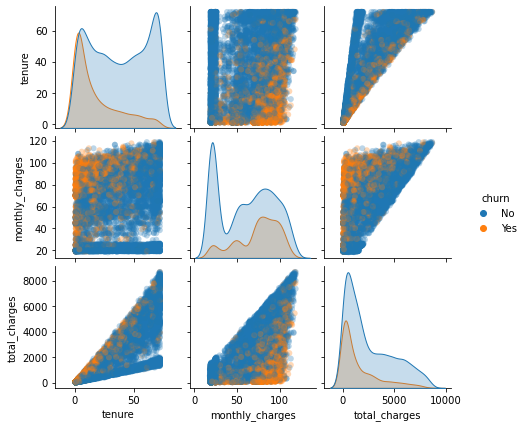

In [39]:
sns.pairplot(df[['tenure', 'monthly_charges', 'total_charges', 'churn']], 
             hue='churn', plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1)

array([<AxesSubplot:title={'center':'tenure'}>,
       <AxesSubplot:title={'center':'monthly_charges'}>,
       <AxesSubplot:title={'center':'total_charges'}>], dtype=object)

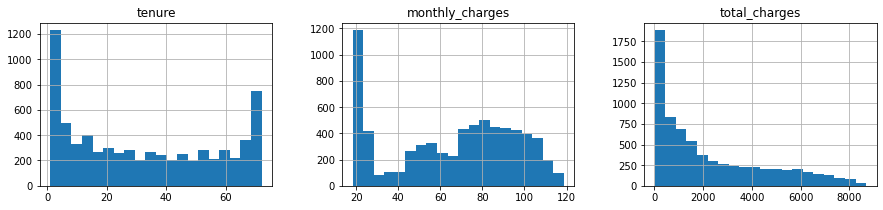

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
df[num_cols].hist(bins=20, figsize=(10, 7), ax=ax)

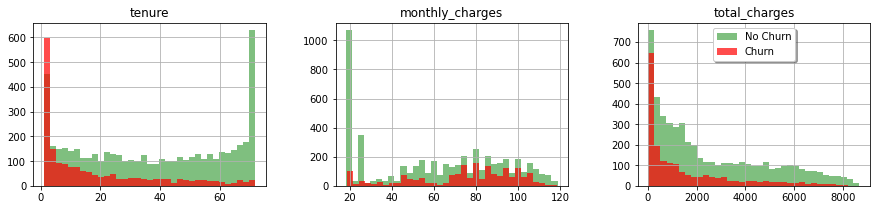

In [47]:
# look at distributions of numerical features in relation to the target variable
# the greater TotalCharges and tenure are the less is the probability of churn

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
df[df.churn == "No"][num_cols].hist(bins=35, color="green", alpha=0.5, ax=ax)
df[df.churn == "Yes"][num_cols].hist(bins=35, color="red", alpha=0.7, ax=ax)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=9)

In [9]:
# I'll create some categorical transformations of this numerical content for the model
# ideally it won't cause complications and will instead let me better narrow my results.

# creates categorical column for monthly_charges
def monthly_charges_splits(df) :   
    if df['monthly_charges'] <= 25 :
        return '0-25'
    elif (df['monthly_charges'] > 25) & (df['monthly_charges'] <= 50 ):
        return '26-50'
    elif (df['monthly_charges'] > 50) & (df['monthly_charges'] <= 75 ):
        return '51-75'
    elif (df['monthly_charges'] > 75) & (df['monthly_charges'] <= 100 ):
        return '76-100'
    elif df['monthly_charges'] > 100 :
        return '>100'
df['monthlycharges_group'] = df.apply(lambda df:monthly_charges_splits(df), axis = 1)

# creates categorical column for total_charges
def total_charges_splits(df) :   
    if df['total_charges'] <= 2000 :
        return '0-2k'
    elif (df['total_charges'] > 2000) & (df['total_charges'] <= 4000 ):
        return '2k-4k'
    elif (df['total_charges'] > 4000) & (df['total_charges'] <= 6000) :
        return '4k-6k'
    elif df['total_charges'] > 6000 :
        return '>6k'
df['totalcharges_group'] = df.apply(lambda df:total_charges_splits(df), axis = 1)

# creates categorical column for tenure
def tenure_splits(df) :   
    if df['tenure'] <= 6 :
        return '1-6'
    elif (df['tenure'] > 6) & (df['tenure'] <= 12 ):
        return '6-12'
    elif (df['tenure'] > 12) & (df['tenure'] <= 18) :
        return '13-18'
    elif df['tenure'] > 18 & (df['tenure'] <= 24) :
        return '19-24'
    elif df['tenure'] > 24 :
        return '>24'
df['tenure_months'] = df.apply(lambda df:tenure_splits(df), axis = 1)

# # Separating categorical and numerical columns
# Id_col     = ['customerID']
# target_col = ['Churn']
# cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
# cat_cols   = [x for x in cat_cols if x not in target_col]
# num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]

# target_col

In [10]:
describe_data(df)

The first three rows are: 
----------------------------------------------------------
   payment_type_id  internet_service_type_id  contract_type_id customer_id  \
0                2                         1                 2  0002-ORFBO   
1                2                         1                 1  0003-MKNFE   
2                1                         2                 1  0004-TLHLJ   

   gender senior_citizen partner dependents  tenure phone_service  ...  \
0  Female             No     Yes        Yes       9           Yes  ...   
1    Male             No      No         No       9           Yes  ...   
2    Male             No      No         No       4           Yes  ...   

  paperless_billing monthly_charges total_charges churn   contract_type  \
0               Yes            65.6        593.30    No        One year   
1                No            59.9        542.40    No  Month-to-month   
2               Yes            73.9        280.85   Yes  Month-to-month   

  i

No     5163
Yes    1869
Name: churn, dtype: int64
 The percentage of churn customers is 26.58%


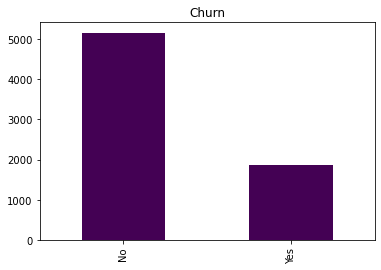

In [11]:
# Churn distribution is unbalanced. This was already known, but may as well be depicted. 
print(df.churn.value_counts())
df['churn'].value_counts().plot(kind='bar', colormap='viridis').set_title('Churn')
print(f' The percentage of churn customers is {1869/(5163+1869):.2%}')

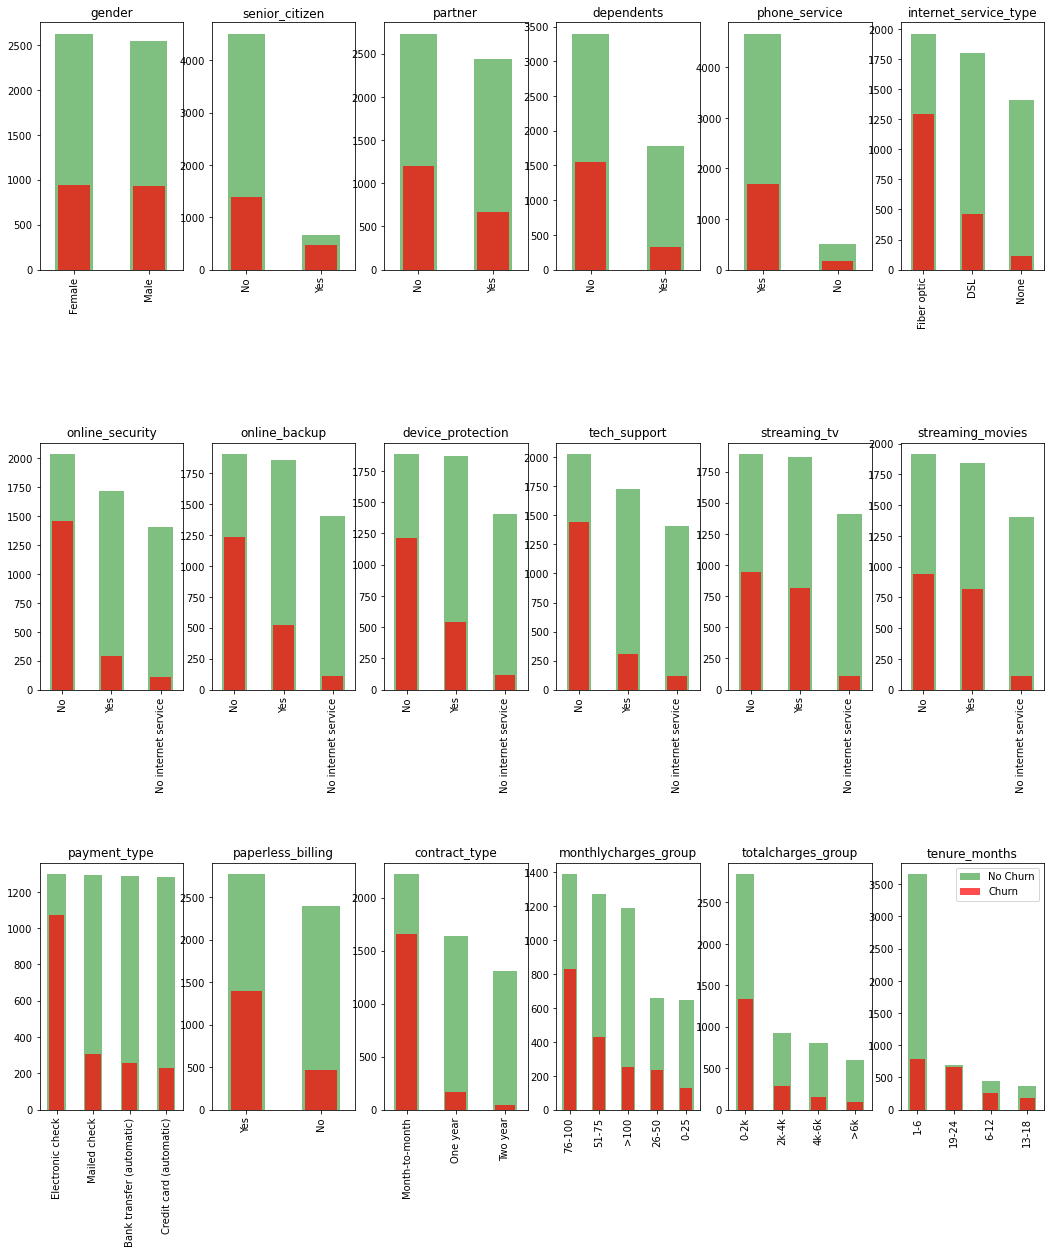

In [58]:
# categorical feature distribution, one form of analysis. 
# Note: senior citizens and customers without phone service have far less representation in the data
# "No Internet Service" is a repeated feature in 6 other charts
# This is merely a manner of visually conveying much of what is already known to me, but not
# the audience. Green is good, red is bad. 

categorical_features = [
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'internet_service_type',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'payment_type',
 'paperless_billing',
 'contract_type',
 'monthlycharges_group',
 'totalcharges_group',
 'tenure_months'
]

ROWS, COLS = 3, 6
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 20) )
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
#     df[categorical_feature].value_counts().plot('bar', ax=ax[row, col]).set_title(categorical_feature)
    df[df.churn=='No'][categorical_feature].value_counts().plot(kind='bar', 
                width=.5, ax=ax[row, col], color='green', alpha=0.5).set_title(categorical_feature)
    df[df.churn=='Yes'][categorical_feature].value_counts().plot(kind='bar', 
                width=.42, ax=ax[row, col], color='red', alpha=0.7).set_title(categorical_feature)
    plt.legend(['No Churn', 'Churn'])
    fig.subplots_adjust(hspace=0.7)

In [76]:
# store df to csv file
df.to_csv('project_draft.csv', index=False)
# index keeps appearing. must be dropped. 

In [77]:
# change the get data function
# Acquisition

def get_telco_data(use_cache=True):
# filename = 'project.csv'
    
    if os.path.exists('project_draft.csv') and use_cache:
        print('Using cached csv')
        return pd.read_csv('project_draft.csv')
    print('Acquiring data from SQL database')
    df = pd.read_sql('''   
                    SELECT * 
                        FROM customers
                        JOIN contract_types USING(contract_type_id)
                        JOIN internet_service_types USING(internet_service_type_id)
                        JOIN payment_types USING(payment_type_id)
                    '''
            , get_db_url('telco_churn'))
    
    df.to_csv('telco.csv', index=False)
    
    return df




In [129]:
df = get_telco_data()
describe_data(df)

Using cached csv
The first three rows are: 
----------------------------------------------------------
   Unnamed: 0  payment_type_id  internet_service_type_id  contract_type_id  \
0           0                2                         1                 2   
1           1                2                         1                 1   
2           2                1                         2                 1   

  customer_id  gender senior_citizen partner dependents  tenure  ...  \
0  0002-ORFBO  Female             No     Yes        Yes       9  ...   
1  0003-MKNFE    Male             No      No         No       9  ...   
2  0004-TLHLJ    Male             No      No         No       4  ...   

  paperless_billing monthly_charges total_charges churn   contract_type  \
0               Yes            65.6        593.30    No        One year   
1                No            59.9        542.40    No  Month-to-month   
2               Yes            73.9        280.85   Yes  Month-to-mont

In [130]:
#describe_data(df)
# new groups have been included. 
df = df.drop(columns=['customer_id', 'payment_type_id', 'internet_service_type_id',
                      'contract_type_id', 'Unnamed: 0'])
#describe_data(df)

In [131]:
# Data preprocessing

# Encode the categorical variables with three or less values.
# however, make dummies for the online services like security
# that way I can removed cases where there's no internet service
# since that is irrelevant to this. 

df['is_senior'] = np.where(df.senior_citizen == 'Yes', 1, 0)
df['is_male'] = np.where(df.gender == 'Male', 1, 0)
df['has_partner'] = np.where(df.partner == 'Yes', 1, 0)
df['has_dependent'] = np.where(df.dependents == 'Yes', 1, 0)
df['has_phone'] = np.where(df.phone_service == 'Yes', 1, 0)
df['multiple_lines'] = np.where(df.multiple_lines == 'Yes', 1, 0)
df['has_internet'] = np.where(df.internet_service_type == "None", 0, 1)
df['fiber'] = np.where(df.internet_service_type == "Fiber optic", 1, 0)
df['dsl'] = np.where(df.internet_service_type == "DSL", 1, 0)
df['pays_monthly'] = np.where(df.contract_type == "Month-to-month", 1, 0)
df['two_year_contract'] = np.where(df.contract_type == "Two Year", 1, 0)
df['electronic_check'] = np.where(df.payment_type == "Electronic check", 1, 0)
df['autopay'] = np.where(df.payment_type.str.contains('automatic') == True, 1, 0)
df['churn'] = np.where(df.churn == 'Yes', 1, 0)

# drop redundant, categorical variables. 
df = df.drop(columns=['gender', 'partner', 'dependents', 'phone_service',
                      'multiple_lines', 'internet_service_type', 'contract_type',
                      'payment_type', 'paperless_billing', 'senior_citizen'
                     ])

In [100]:
describe_data(df)

The first three rows are: 
----------------------------------------------------------
   tenure online_security online_backup device_protection tech_support  \
0       9              No           Yes                No          Yes   
1       9              No            No                No           No   
2       4              No            No               Yes           No   

  streaming_tv streaming_movies  monthly_charges  total_charges  churn  ...  \
0          Yes               No             65.6         593.30      0  ...   
1           No              Yes             59.9         542.40      0  ...   
2           No               No             73.9         280.85      0  ...   

  has_dependent has_phone has_internet  fiber  dsl  pays_monthly  \
0             1         1            1      0    1             0   
1             0         1            1      0    1             1   
2             0         1            1      1    0             1   

   two_year_contract  elect

In [132]:
new_kids_on_campus = ['online_security', 'online_backup', 'device_protection', 'tech_support',
                     'streaming_tv', 'streaming_movies']

for col in new_kids_on_campus:
    dummy_df = pd.get_dummies(df[col],
                              prefix=f'enc_{df[col].name}',
                              drop_first=False,
                              dummy_na=False)
# set drop_first to false because I would rather remove cases where there is no internet service
# I will do so manually. 
    # add the columns to the dataframe
    df = pd.concat([df, dummy_df], axis=1)
    
## clean up the column names
#for col in df.columns:
#    df = df.rename(columns={col: col.lower()})
#    df = df.rename(columns={col: col.replace(' ', '_')})
#df = df.rename(columns={'enc_churn_yes': 'enc_churn'})

In [133]:
df.dtypes

tenure                                         int64
online_security                               object
online_backup                                 object
device_protection                             object
tech_support                                  object
streaming_tv                                  object
streaming_movies                              object
monthly_charges                              float64
total_charges                                float64
churn                                          int64
monthlycharges_group                          object
totalcharges_group                            object
tenure_months                                 object
is_senior                                      int64
is_male                                        int64
has_partner                                    int64
has_dependent                                  int64
has_phone                                      int64
has_internet                                  

In [134]:
# there are a lot of repeated features (no internet service), and are of no interested directly
# plus, through the other two, the third can be presumed. 
df = df.drop(columns=['enc_online_security_No internet service', 'enc_online_backup_No internet service', 
                        'enc_device_protection_No internet service', 'enc_tech_support_No internet service', 
                        'enc_streaming_tv_No internet service', 'enc_streaming_movies_No internet service'], axis=1)

In [135]:
df.dtypes
# now I can drop the object class versions of these. 
df = df.drop(columns=new_kids_on_campus)

In [136]:
#df.dtypes
# now I can divvy up these groups of charges and be on my way to scaling. 
numerical_numbskulls = ['monthlycharges_group','totalcharges_group','tenure_months']

for col in numerical_numbskulls:
    dummy_df = pd.get_dummies(df[col],
                              prefix=f'enc_{df[col].name}',
                              drop_first=True,
                              dummy_na=False)
    
    # add the columns to the dataframe
    df = pd.concat([df, dummy_df], axis=1)

In [137]:
describe_data(df)

The first three rows are: 
----------------------------------------------------------
   tenure  monthly_charges  total_charges  churn monthlycharges_group  \
0       9             65.6         593.30      0                51-75   
1       9             59.9         542.40      0                51-75   
2       4             73.9         280.85      1                51-75   

  totalcharges_group tenure_months  is_senior  is_male  has_partner  ...  \
0               0-2k          6-12          0        0            1  ...   
1               0-2k          6-12          0        1            0  ...   
2               0-2k           1-6          0        1            0  ...   

   enc_monthlycharges_group_26-50  enc_monthlycharges_group_51-75  \
0                               0                               1   
1                               0                               1   
2                               0                               1   

   enc_monthlycharges_group_76-100  enc

In [140]:
num_cols = ['monthly_charges', 'total_charges']

#Scaling Numerical columns
scaler = StandardScaler()
scaled = scaler.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df1 = df.drop(columns = num_cols, axis = 1)
df1 = df1.merge(scaled, left_index=True, right_index=True, how = "left")

In [141]:
describe_data(df1)

The first three rows are: 
----------------------------------------------------------
   tenure  churn monthlycharges_group totalcharges_group tenure_months  \
0       9      0                51-75               0-2k          6-12   
1       9      0                51-75               0-2k          6-12   
2       4      1                51-75               0-2k           1-6   

   is_senior  is_male  has_partner  has_dependent  has_phone  ...  \
0          0        0            1              1          1  ...   
1          0        1            0              0          1  ...   
2          0        1            0              0          1  ...   

   enc_monthlycharges_group_76-100  enc_monthlycharges_group_>100  \
0                                0                              0   
1                                0                              0   
2                                0                              0   

   enc_totalcharges_group_2k-4k  enc_totalcharges_group_4k-6k  

In [142]:
df1 = df1.drop(columns=numerical_numbskulls)

In [143]:
df1.dtypes

tenure                               int64
churn                                int64
is_senior                            int64
is_male                              int64
has_partner                          int64
has_dependent                        int64
has_phone                            int64
has_internet                         int64
fiber                                int64
dsl                                  int64
pays_monthly                         int64
two_year_contract                    int64
electronic_check                     int64
autopay                              int64
enc_online_security_No               uint8
enc_online_security_Yes              uint8
enc_online_backup_No                 uint8
enc_online_backup_Yes                uint8
enc_device_protection_No             uint8
enc_device_protection_Yes            uint8
enc_tech_support_No                  uint8
enc_tech_support_Yes                 uint8
enc_streaming_tv_No                  uint8
enc_streami

In [144]:
# store this new dataframe to its own csv file. 
df1.to_csv('cleaned_telco.csv', index=False)